In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.initialize_interpolation_grid(500, grid_bounds=[(0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel().cuda()
model.condition(train_x, train_y)

KissGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [4]:
# Optimize the model
def train():
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(output, train_y) * 1. / len(train_x)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()

    _ = model.eval()
    
%time train()

/home/gpleiss/anaconda2/lib/python2.7/site-packages/torch/tensor.py:300: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)
/home/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/30 - Loss: 1.095
Iter 2/30 - Loss: 1.013
Iter 3/30 - Loss: 1.062
Iter 4/30 - Loss: 0.977
Iter 5/30 - Loss: 1.028
Iter 6/30 - Loss: 0.883
Iter 7/30 - Loss: 0.928
Iter 8/30 - Loss: 0.798
Iter 9/30 - Loss: 0.708
Iter 10/30 - Loss: 0.368
Iter 11/30 - Loss: 0.622
Iter 12/30 - Loss: 0.774
Iter 13/30 - Loss: 0.441
Iter 14/30 - Loss: 0.536
Iter 15/30 - Loss: 0.411
Iter 16/30 - Loss: 0.195
Iter 17/30 - Loss: -0.008
Iter 18/30 - Loss: 0.195
Iter 19/30 - Loss: 0.023
Iter 20/30 - Loss: 0.179
Iter 21/30 - Loss: 0.153
Iter 22/30 - Loss: -0.344
Iter 23/30 - Loss: -0.315
Iter 24/30 - Loss: -0.200
Iter 25/30 - Loss: -0.176
Iter 26/30 - Loss: -0.429
Iter 27/30 - Loss: -0.276
Iter 28/30 - Loss: -0.216
Iter 29/30 - Loss: -0.420
Iter 30/30 - Loss: -0.472
CPU times: user 3.17 s, sys: 3.81 s, total: 6.98 s
Wall time: 6.99 s


In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51)).cuda()
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
        ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
        ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

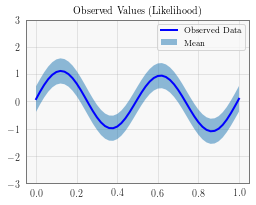

In [6]:
f = plot_model_and_predictions(model, plot_train_data=False)